In [7]:
import pandas as pd
import matplotlib.pyplot as plt

from dataframe import ResultsDataFrame
from pandas_functions import filter_df, possible_combinations
from dictionaries import phenotype_dict, par1_order, baz_order

In [8]:
def phenotype_counter(df, x_variable, colnames):
    '''
    Takes panda DataFrame, column name x_variable, list of column names to consider
    
    Returns list of unique values in x_variable column, total number of oocytes for each unique value in x_variable column, list of tuples containing number of occurances of unique combinations of phenotypes for each value of x_variable, and list of dictionaries containing unique combinations of phenotypes
    '''

    combinations = possible_combinations(df, colnames)

    phenotypes_list = []
    unique_values = df[x_variable].unique()
    
    for x in unique_values:
        df2 = filter_df(df, x_variable, x)
        phenotypes_sublist = [len(filter_df(df2, colnames, list(combination.values()))) for combination in combinations]
        phenotypes_list.append(phenotypes_sublist)

    sample_size = [sum(s) for s in phenotypes_list]
    phenotypes_list = list(zip(*phenotypes_list))

    return list(unique_values), sample_size, phenotypes_list, combinations

In [9]:
def extract_data(df, x_variable, colnames, fixed_variable=None, fixed_value=None, filter_out_nan=True, additional_filters=None):
    '''
    Extracts data from the dataframe df, based on Variable x_variable (e.g. Stage), phenotypes specified in list of colnames (e.g. ["PosteriorGap", "LateralGap", "BazookaExclusion"]), and optional fixed_variable
    Returns ResultsDataFrame object containing information necessary for making plots using make_stacked_plot function
    '''
    if fixed_variable:
        df = filter_df(df, fixed_variable, fixed_value)

    filter=[]
    if filter_out_nan: filter+=[float("nan")]
    if additional_filters:
        if type(additional_filters)!=list:
            raise TypeError("additional_list argument must be of type list")
        else:
            filter+=additional_filters
    if len(colnames)>1: filter=[filter]*len(colnames)
    
    if len(filter)>0:
        df = filter_df(df, colnames, filter, filter_out=True)

    phenotypes_count = phenotype_counter(df, x_variable, colnames)
    
    return ResultsDataFrame(x_variable, phenotypes_count[0], phenotypes_count[1], phenotypes_count[2], phenotypes_count[3])

In [39]:
def make_stacked_plot(results_object, use_percentages=False, x_order=None, xlabel=None, title=None, width=0.5, legend_order=None, colors=None, x_labels_rotation=0, font_size=18, background_color='black'):


    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    from pylab import cm

    # Edit the font, font size, color and axes width
    mpl.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = font_size
    plt.rcParams['axes.linewidth'] = 1

    COLOR = background_color
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR


    x_labels = list(results_object.x_values)
    all_data = list(results_object.data)
    sample_size = list(results_object.sample_size)
    legend = list(results_object.legend)

    if x_order:
        # reorder data:
        new_indices = [x_labels.index(o) for o in x_order]
        for ind, d in enumerate(all_data):
            all_data[ind] = [d[i] for i in new_indices]
        # reorder sample size:
        sample_size = [sample_size[i] for i in new_indices]
        # reorder labels:
        x_labels = x_order

    if legend_order:
        all_data = [all_data[legend.index(label)] for label in legend_order]
        legend = legend_order

    if not xlabel:
        xlabel = results_object.x_name

    x_labels = [l+'(n='+str(n)+')' for l, n in zip(x_labels, sample_size)]
    
    fig, ax = plt.subplots()
    bottom = [0]*len(x_labels)
    for index, data in enumerate(all_data):
        if sum(data) > 0:  # only do further processing if there are values other than 0
            legend_label = ""
            for key, value in legend[index].items():
                try:
                    legend_label += (str(phenotype_dict[key]
                                         )+":"+str(value) + ", ")
                except:
                    legend_label += (str(key)+":"+str(value) + ", ")

            if use_percentages:
                data = [d/sample_size[ind]*100 for ind, d in enumerate(data)]

            if colors:
                ax.bar(x_labels, data, width, bottom=bottom,
                       label=legend_label, color=colors[index])
            else:
                ax.bar(x_labels, data, width, bottom=bottom, label=legend_label)

            bottom = [b+d for b, d in zip(bottom, data)]

    # Title
    if title:
        ax.set_title(title)

    ax.set_xlabel(xlabel)  # main x label
    plt.xticks(rotation=x_labels_rotation)  # rotation of x labels
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fancybox=True, framealpha=0.0)  # position of legend

    # y label
    if use_percentages:
        ax.set_ylabel('% of oocytes')
    else:
        ax.set_ylabel('Number of oocytes')

    plt.show()
    return fig

In [11]:
df = pd.read_csv("Results.csv")

fixed_variable = "Genotype"
fixed_value = "w; UASp>Bazooka::mGFP/mata4-GAL4; Jupiter::mCherry/Jupiter::mCherry"
x_variable = "Stage"
phenotypes = ["PosteriorGap", "LateralGap", "BazookaExclusion"]

legend_order = baz_order
colors = ["magenta", "blue", "lightblue", "lightgreen", "green"]

results = extract_data(df, x_variable=x_variable, colnames = phenotypes, fixed_variable=fixed_variable, fixed_value=fixed_value, filter_out_nan=True, additional_filters=["Not clear"])




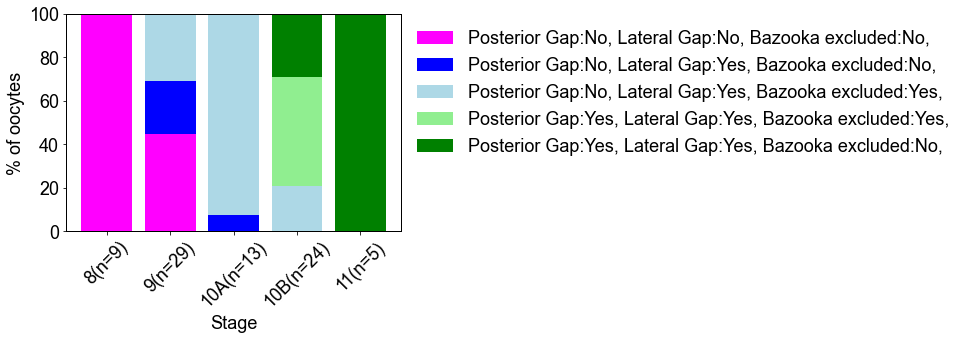

In [42]:
fig = make_stacked_plot(results, use_percentages=True, x_order=["8", "9","10A","10B", "11"], width=0.8, legend_order=legend_order, colors=colors, x_labels_rotation=45, background_color='black')

In [41]:
fig.savefig('Final_Plot.png', dpi=300, transparent=True, bbox_inches='tight')

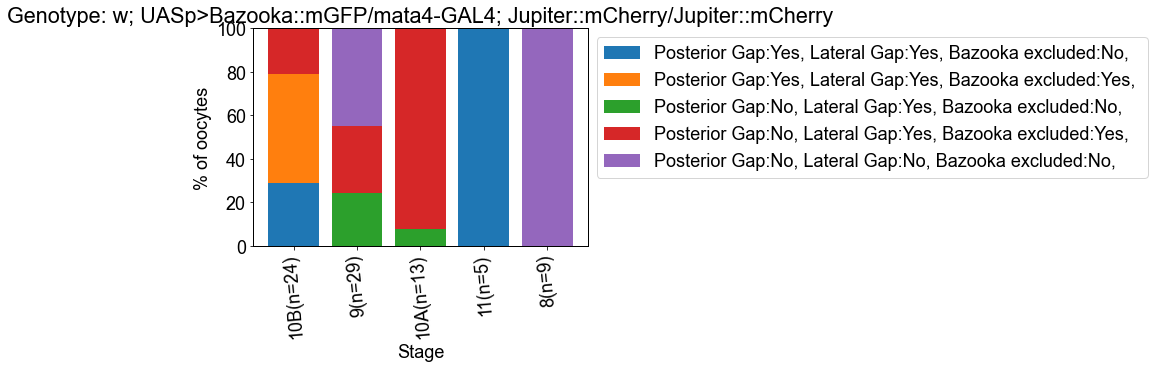

In [13]:
make_stacked_plot(results, use_percentages=True, width=0.8, x_labels_rotation=95, title=f'{fixed_variable}: {fixed_value}')

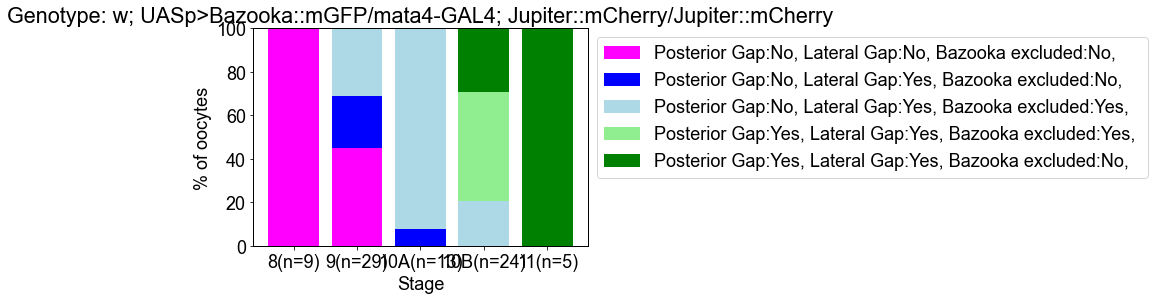

In [14]:
make_stacked_plot(results, use_percentages=True, x_order=["8", "9","10A","10B", "11"], width=0.8, legend_order=legend_order, colors=colors, title=f'{fixed_variable}: {fixed_value}')

In [15]:
@interact
def f(use_percentages=True, fixed_variable=["Genotype", "Stage"], fixed_value=df[fixed_variable].unique()):

    results = extract_data(df, x_variable=x_variable, colnames = phenotypes, fixed_variable=fixed_variable, fixed_value=fixed_value, filter_out_nan=True, additional_filters=["Not clear"])

    #make_stacked_plot(results, use_percentages=use_percentages, x_order=["8", "9","10A","10B", "11"], width=0.8, legend_order=legend_order, colors=colors, title=f'{fixed_variable}: {fixed_value}')

    make_stacked_plot(results, use_percentages=use_percentages)

NameError: name 'interact' is not defined

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

In [35]:
x_widget = FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
interact(printer,x=x_widget, y=y_widget);

interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, step=0.05), FloatSlider(value=5.0, des…

In [136]:
columns = [None, "Genotype", "Stage", "Nucleus", "PosteriorGap", "LateralGap", "BazookaExclusion", "Par1atPosterior"]
possible_phenotypes = ["Genotype", "Stage", "Nucleus", "PosteriorGap", "LateralGap", "BazookaExclusion", "Par1atPosterior"]

def f(use_percentages, x_labels_rotation, x_variable, phenotypes, fixed_variable, fixed_value, filter_out_nan, **kwargs):
    for c in kwargs.values():
        print(c)
    phenotypes = [p for p in phenotypes]
    #x_order=["8", "9","10A","10B", "11"] if x_variable=="Stage" else None
    results = extract_data(df, x_variable=x_variable, colnames = phenotypes, fixed_variable=fixed_variable, fixed_value=fixed_value, filter_out_nan=filter_out_nan, additional_filters=["Not clear"])

    #make_stacked_plot(results, use_percentages=use_percentages, x_order=["8", "9","10A","10B", "11"], width=0.8, legend_order=legend_order, colors=colors, title=f'{fixed_variable}: {fixed_value}')

    make_stacked_plot(results, use_percentages=use_percentages, x_labels_rotation=x_labels_rotation, width=0.8, title=f'{fixed_variable}: {fixed_value}')

x_variable_widget=Dropdown(options=columns, value="Stage", description="x Variable:")

phenotypes_widget=widgets.SelectMultiple(
    options=possible_phenotypes,
    value=['PosteriorGap'],
    #rows=10,
    description='Phenotypes',
    disabled=False
)

color_sliders = [widgets.ColorPicker(
        description=p,
        disabled=False
    ) for p in phenotypes]

kwargs = {'c{}'.format(i):slider for i, slider in enumerate(color_sliders)}

def update_color_sliders(*args):
    color_sliders = [widgets.ColorPicker(
        description=p,
        disabled=False
    ) for p in phenotypes_widget.value()]
    kwargs = {'c{}'.format(i):slider for i, slider in enumerate(color_sliders)}
#phenotypes_widget.observe(update_color_sliders, 'value')

fixed_variable_widget=Dropdown(options=columns)
fixed_value_widget=Dropdown(options=[None]+df.Genotype.unique().tolist(), value=None)

def update_fixed_value_widget(*args):
    fixed_value_widget.options =  df[fixed_variable_widget.value].unique()
fixed_variable_widget.observe(update_fixed_value_widget, 'value')

interact(f, use_percentages=True, x_labels_rotation=(0,90), x_variable=x_variable_widget, phenotypes=phenotypes_widget, fixed_variable=fixed_variable_widget, fixed_value=fixed_value_widget, filter_out_nan=True, **kwargs)

interactive(children=(Checkbox(value=True, description='use_percentages'), IntSlider(value=45, description='x_…

<function __main__.f(use_percentages, x_labels_rotation, x_variable, phenotypes, fixed_variable, fixed_value, filter_out_nan, **kwargs)>

In [63]:
pw=widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    #rows=10,
    description='Fruits',
    disabled=False
)
def f2(p):
    print([i for i in p])

interact(f2,p=pw)

interactive(children=(SelectMultiple(description='Fruits', index=(1,), options=('Apples', 'Oranges', 'Pears'),…

<function __main__.f2(p)>

In [67]:

tab_contents = ['P0', 'P1', 'P2', 'P3', 'P4']
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(i))
tab

In [88]:
p = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)
p.description

'Pick a color'

In [126]:
#colors = [widgets.ColorPicker(description=p) for p in phenotypes]
#colors
color_sliders = [widgets.ColorPicker(
        description=p,
        disabled=False
    ) for p in phenotypes]

kwargs = {'c{}'.format(i):slider for i, slider in enumerate(color_sliders)}
def f2(**kwargs):
    for c in kwargs.values():
        print(c)

interact(f2, **kwargs)


interactive(children=(ColorPicker(value='black', description='PosteriorGap'), ColorPicker(value='black', descr…

<function __main__.f2(**kwargs)>

In [108]:
colors[0]

ColorPicker(value='black', description='PosteriorGap')

In [113]:
n_weights=10
weight_sliders = [widgets.FloatSlider(
        value=0,
        min=-10.0,
        max=10.0,
        step=0.1,
        description='w%d' % i,
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    ) for i in range(n_weights)]

def PlotSuperposition(**kwargs):
    def f(x):
        y = 0
        for i, weight in enumerate(kwargs.values()):
            if i==0:
                y+=weight
            else:
                y += weight*math.sin(x*i)
        return y
    vf = np.vectorize(f)
    xx = np.arange(0,6,0.1)
    plt.plot(xx, vf(xx))
    plt.gca().set_ylim(-5,5)

kwargs = {'w{}'.format(i):slider for i, slider in enumerate(weight_sliders)}

interact(PlotSuperposition, **kwargs)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='w0', max=10.0, min=-10.0, r…

<function __main__.PlotSuperposition(**kwargs)>

In [116]:
kwargs

{'w0': FloatSlider(value=0.0, continuous_update=False, description='w0', max=10.0, min=-10.0, readout_format='.1f'),
 'w1': FloatSlider(value=0.0, continuous_update=False, description='w1', max=10.0, min=-10.0, readout_format='.1f'),
 'w2': FloatSlider(value=0.0, continuous_update=False, description='w2', max=10.0, min=-10.0, readout_format='.1f'),
 'w3': FloatSlider(value=0.0, continuous_update=False, description='w3', max=10.0, min=-10.0, readout_format='.1f'),
 'w4': FloatSlider(value=0.0, continuous_update=False, description='w4', max=10.0, min=-10.0, readout_format='.1f'),
 'w5': FloatSlider(value=0.0, continuous_update=False, description='w5', max=10.0, min=-10.0, readout_format='.1f'),
 'w6': FloatSlider(value=0.0, continuous_update=False, description='w6', max=10.0, min=-10.0, readout_format='.1f'),
 'w7': FloatSlider(value=0.0, continuous_update=False, description='w7', max=10.0, min=-10.0, readout_format='.1f'),
 'w8': FloatSlider(value=0.0, continuous_update=False, descripti